In [ ]:
#hide   
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
from pprint import pprint as pp
from datetime import datetime as dt
from typing import *
import rfpy
from rfpy.parser import *
from rfpy.utils import *
from rfpy.blocks import *
from nbdev.showdoc import *
from fastcore.xtras import Path
from fastcore.foundation import L
from fastcore.test import *
import numpy as np
import pandas as pd

In [ ]:
#hide
%load_ext autoreload
%autoreload 2 

Caminho das pastas de entrada e saída

In [ ]:
entrada = Path(r'C:\Users\rsilva\Downloads\entrada')
saida = Path(r'C:\Users\rsilva\Downloads\saida')

Função que mapeia os arquivos da pasta e retorna um lista generalizada `L`

In [ ]:
arquivos = get_files(entrada) ;  arquivos

(#3) [Path('C:/Users/rsilva/Downloads/entrada/201201_T153421_OneThreadID.bin'),Path('C:/Users/rsilva/Downloads/entrada/201201_T154509_MultiplesThreadID.bin'),Path('C:/Users/rsilva/Downloads/entrada/rfeye002304_SLMA_bimestral_PEAK_200829_234902.bin')]

Peguemos 1 arquivo com somente 1 thread_id por bloco e 1 com múltiplos thread_ids por bloco.

In [ ]:
one_tid = arquivos[-1]
mult_tid = arquivos[1]

On a normal conda environment the time of the following cell was
```python
%%timeit
one = process_bin(one_tid)
```
1.22 s ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
%%time
one = parse_bin(one_tid)

Wall time: 529 ms


On a normal conda environment the time of the following cell was
```python
%%timeit
multi = process_bin(mult_tid)
```
1.29 s ± 73.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
%%time
multi = parse_bin(mult_tid)

Wall time: 1.27 s


In [ ]:
multi.keys()

dict_keys(['file_version', 'string', 'blocos'])

In [ ]:
multi['file_version']

22

In [ ]:
multi['string']

'CRFS DATA FILE V022'

In [ ]:
multi['blocos']

defaultdict(fastcore.foundation.L,
            {(21,
              0): (#1) [((36, 123), <rfpy.blocks.DType21 object at 0x000002686CE897C8>)],
             (41,
              0): (#2) [((128, 203), <rfpy.blocks.DType41 object at 0x000002686CE89A48>),((208, 335), <rfpy.blocks.DType41 object at 0x00000268512D5888>)],
             (24,
              5): (#1) [((340, 375), <rfpy.blocks.DType24 object at 0x000002686CE70648>)],
             (24,
              10): (#1) [((380, 427), <rfpy.blocks.DType24 object at 0x000002686CE70788>)],
             (24,
              20): (#1) [((432, 487), <rfpy.blocks.DType24 object at 0x000002686CE705C8>)],
             (24,
              30): (#1) [((492, 547), <rfpy.blocks.DType24 object at 0x000002686CE70988>)],
             (24,
              40): (#1) [((552, 607), <rfpy.blocks.DType24 object at 0x000002686CE706C8>)],
             (24,
              50): (#1) [((612, 667), <rfpy.blocks.DType24 object at 0x000002686CE70888>)],
             (24,
      

In [ ]:
exemplo = multi['blocos'][(21,0)][0]

In [ ]:
bytes_map = exemplo[0]
bloco = exemplo[1]

In [ ]:
bin_data = bloco.data ; bin_data

b'rfeye002292\x00\x00\x00\x00\x00\x18\x00\x00\x00CRFS default unit info\x00\x00\x14\x00\x00\x00CRFS default method\x00\x00\x00\x00'

In [ ]:
len(bin_data)

71

In [ ]:
getattrs(bloco)

{'data_size': 72,
 'file_number': 0,
 'hostname': 'rfeye002292',
 'method': 'CRFS default method',
 'thread_id': 0,
 'type': 21,
 'unit_info': 'CRFS default unit info'}

In [ ]:
bloco._text1_len

24

In [ ]:
bloco._text2_len

20

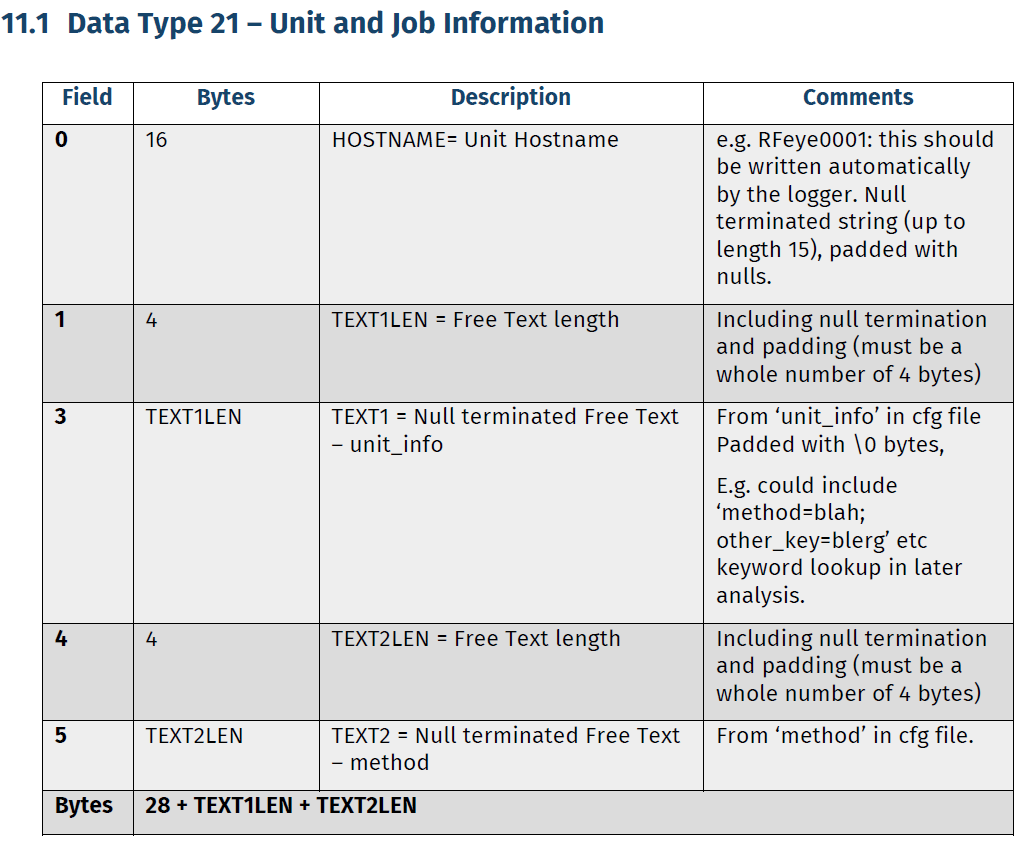

In [ ]:
28 + bloco._text1_len + bloco._text2_len

72

Teoricamente o tamanho do bloco disponível no cabeçalho do bloco é 72, no entanto em todos os blocos encontrados até o momento o tamanho real do bloco é sempre decrementado em 1.

### Mapeamento dos bytes do arquivo nos blocos

Vamos testar se o mapeamento do bloco nos bytes do arquivo está correto, para tal vamos ler o arquivo novamente.

In [ ]:
with open(mult_tid, mode='rb') as bfile:
    # O primeiro bloco do arquivo é o cabeçalho e tem 36 bytes de tamanho.
    body = bfile.read()

Primeiramente criamos um Bloco Base - Cabeçalho, Dados e Rodapé com a função `create_base_block`.

In [ ]:
show_doc(create_base_block)

<h4 id="create_base_block" class="doc_header"><code>create_base_block</code><a href="https://github.com/ronaldokun/rfpy/tree/master/rfpy/blocks.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>create_base_block</code>(**`bin_block`**:`bytes`)

A block is a piece of the .bin file with a known start and end and that contains different types of information.
It has several fields: type, header, data and footer.
Each field has lengths and information defined in the documentation.
Receives a block from the bin file and returns a Base Block instance with the attributes
'thread_id', 'block_size', 'block_type', 'block_data', 'checksum'

In [ ]:
block = create_base_block(body[slice(*bytes_map)])

Como vemos na documentação da função acima ela aceita arquivos abertos lidos como `bytes`. Passamos para ela o arquivo aberto `body`, mas somente selecionando deste os índices de bytes `bytes_map` retornados acima.
`body[slice(*bytes_map)]` é o mesmo que `body[bytes_map[0]:bytes_map[1]]` mas numa notação mais _pythônica_   

In [ ]:
block.data

b'rfeye002292\x00\x00\x00\x00\x00\x18\x00\x00\x00CRFS default unit info\x00\x00\x14\x00\x00\x00CRFS default method\x00\x00\x00\x00'

A função de teste a seguir testa a igualdade do bloco de dados acima e do bloco de dados diretamente mapeado nos bins, o teste foi bem sucedido caso nada seja retornado

In [ ]:
test_eq(bin_data, block.data)

In [ ]:
metadados = extract_metadata(multi['blocos'])

In [ ]:
metadados[0][1]

,start_byte,stop_byte,data_size,file_number,hostname,method,thread_id,type,unit_info
0,36,123,72,0,rfeye002292,CRFS default method,0,21,CRFS default unit info


In [ ]:
metaone = extract_metadata(one['blocos'])